### Transfer learning

Install and import packages

In [315]:
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install torchvision
# %pip install helper
# %pip install tqdm

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as th
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
import os
from tqdm import tqdm
from xml.dom import minidom


### Load dataset
Maybe normalize dataset

In [317]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as tttttt
import random

np.random.seed(100)

def open_image(path): # https://jovian.ai/aakashns/transfer-learning-pytorch
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AugmentedDataset(Dataset):
    def __init__(self, subset):
        self.standardImagesAdded = 0
        self.length = len(subset.dataset)
        self.subset = th.utils.data.ConcatDataset([subset, subset, subset]) # Add data
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(degrees=(0, 180)),
                                            transforms.Resize(255),
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                            ]) # normalization ABC
        
    def __getitem__(self, index):
        if (self.standardImagesAdded < self.length): # Add standard images
            self.standardImagesAdded += 1
            return self.subset[index]
        
        # Add augmented images
        x, y = self.subset[index]
        t = tttttt.ToPILImage()
        x = self.transform(t(x))
        return x, y
        
    def __len__(self):
        return len(self.subset)
    

class MyDataset(Dataset):
    def __init__(self, binary=False, limit=1):
        super().__init__()
        self.size=224
        self.files = self.initPaths(limit)
        self.binary = binary
        self.classes = self.initClasses() if not binary else self.initClassesCatDog()
        # TODO: fix transforms better
        self.transform = self.getTransform()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = "./data/images/" + self.files[i]
        img = self.transform(open_image(path))
        class_idx = self.classes.index(self.getClass(self.files[i]))

        return img, class_idx
    
    def getTransform(self):
        return transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]) # normalization ABC

    
    def getCenterBoundingBox(self, fileName):
        try:
            file = minidom.parse('./annotations/xmls/'+fileName.replace(".jpg", '.xml'))
            xmin = file.getElementsByTagName('xmin')[0].firstChild.data
            xmax = file.getElementsByTagName('xmax')[0].firstChild.data
            ymin = file.getElementsByTagName('ymin')[0].firstChild.data
            ymax = file.getElementsByTagName('ymax')[0].firstChild.data
            return int(xmin), int(xmax), int(ymin), int(ymax)
        except:
            return 0, 0, 0, 0
    
    
    def getCropStats(self):
        x = 0
        y = 0
        n = 0
        x_li = []
        y_li = []
        
        for file in self.files:
            xmin, xmax, ymin, ymax = self.getCenterBoundingBox(file)
            if (xmin != 0) and (xmax != 0) and (ymin != 0) and (ymax != 0):
                n += 1
                
                x += (xmax + xmin)/2
                y += (ymax + ymin)/2
                
                x_li.append(x)
                y_li.append(y)
                
        print("Average x:", x/n, "Average y:", y/n)
        
        x_np = np.asarray(x_li)
        y_np = np.asarray(y_li)
        
        x_std = np.std(x_np)
        y_std = np.std(y_np)
        print("STD x:", x_std, "STD y:", y_std)
            
            
    # Classifies data into Cat/Dog or into one of the 37 classes of breeds
    def getClass(self, fileName):
        self.getCenterBoundingBox(fileName)
        if self.binary:
            return self.getClassCatDog(fileName)
        else:
            nameList = fileName.split("_")
            name = ""
            for namePart in nameList:
                if ".jpg" not in namePart:
                    name += namePart
            return name
        
    def initClasses(self):
        classList = []
        for fname in self.files:
            theClass = self.getClass(fname)
            if theClass not in classList:
                classList.append(theClass)
        return classList
    
    def getClassCatDog(self, fileName):
       if fileName[0].isupper():
           return "cat"
       else:
           return "dog"
    
    def initClassesCatDog(self):
        classList = []
        for fname in self.files:
            theClass = self.getClass(fname)
            if theClass not in classList:
                classList.append(theClass)
        return ["cat", "dog"]
    
    def initPaths(self, limit):
        files = os.listdir("./data/images/")
        jpgList = []
        for file in files:
            if file.endswith(".jpg"):
                jpgList.append(file)
        random.shuffle(jpgList)
        return jpgList[0:int(len(jpgList)*limit)]
    

test = MyDataset(False)
# test.getCropStats()

In [318]:
from torch.utils.data import random_split

def initDataset(batch_size, binary): #batch size affects computation time
    dataset = MyDataset(binary)
    # Train/Validation/Test split. Current: 70/15/15
    train, test = random_split(dataset, [int(0.85*len(dataset))+1, int(0.15*len(dataset))])
    valid, train = random_split(train, [int(0.176*len(train))+1, int((1-0.176)*len(train))]) # Rounding error
    
    # print(len(train), len(valid), len(test))
    # print(len(train)+ len(valid)+ len(test), len(dataset))
    
    # Enable augementation for the training dataset
    augmentedDataset = AugmentedDataset(train)
    
    train_loader = th.utils.data.DataLoader(augmentedDataset,
                                            batch_size=batch_size, 
                                            shuffle=True)
    
    test_loader = th.utils.data.DataLoader(test,
                                            batch_size=batch_size,
                                            shuffle=True)
    valid_loader = th.utils.data.DataLoader(valid,
                                            batch_size=batch_size,
                                            shuffle=True)
    
    return train_loader , test_loader, valid_loader

train_loader, test_loader, valid_loader = initDataset(batch_size=32, binary=False)

TypeError: unsupported operand type(s) for *: 'Subset' and 'int'

### Inspect dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


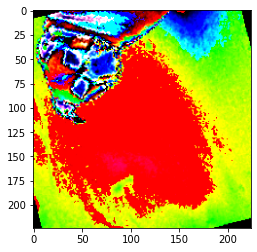

tensor(33)


In [ ]:
n = 0
for batch_idx, batch in enumerate(train_loader):
    images = batch[0]
    labels = batch[1]


    for i in range(len(images)):
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
        print(labels[i])
        n += 1
        if n == 1:
            break
    break

### Initialize model

In [ ]:
model = tv.models.resnet18(progress = True, pretrained=True)
# model.eval()

In [ ]:

#Set requires_grad to false for every layer
moreLayers = True
for param in model.parameters():
    param.requires_grad = False
    
# Replace the last layer of the pretrained model with our own:
# This should theoretically only set the last layer to requires_grad = True, since it is the default setting
model.fc = th.nn.Linear(model.fc.in_features, 37) # 37 if not binary

# Set the second layer to requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True


# Replace more layers:
# TODO: implement

# Examine different learning rates / rate schedulers
# TODO: implement

# Apply data augmentation during training (flip, small rotations, crops, small size scaling)
# TODO: implement

# Effect of fine-tuning or not the batch-norm parameters and updating the estimate of the batch 
# mean and standard deviations on the final performance on the new dataset.

In [ ]:
# Train the model on our dataset
def train_model(model, train_loader, valid_loader, epochs=5, lr=10**-3, weight_decay=0.0):
    # Define the loss function
    criterion = th.nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = th.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay) # filter(lambda p: p.requires_grad, model.parameters()),
    
    # Set different learning rates for different layers
    optimizer.add_param_group({'params': model.layer4.parameters(), 'lr': lr/10})
    
    # Train the model
    scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    
    for epoch in range(epochs):
        # Training
        model.train() #trains model
        for batch_idx, batch in enumerate(tqdm(train_loader)):
            images = batch[0]
            labels = batch[1]
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad() # Reset the gradients, maybe we should not do this
            loss.backward() # Compute the gradients
            optimizer.step() # Update the weights
        # Validation
        scheduler.step()
        model.eval()
        with th.no_grad(): # Disables tracking of calculations required to calculate gradients
            correct = 0
            total = 0
            for batch_idx, batch in enumerate(valid_loader):
                images = batch[0]
                labels = batch[1]
                #print(labels)
                outputs = model(images)
                #print(outputs)
                _, predicted = th.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print('Learning rate: {} \n'.format(lr))
            print('Accuracy of the network on the validation images: {} %'.format(100 * correct / total))
            
    return model

new = train_model(model, train_loader, valid_loader, epochs=20, lr=10**-2 , weight_decay=0.0)
#new = train_model(model, train_loader, valid_loader, epochs=5, lr=10**-2, weight_decay=0.0)
#new = train_model(model, train_loader, valid_loader, epochs=5, lr=10**-3, weight_decay=0.0)
#new = train_model(model, train_loader, valid_loader, epochs=5, lr=10**-4, weight_decay=0.0)

100%|██████████| 162/162 [15:50<00:00,  5.87s/it]


Learning rate: 0.01 

Accuracy of the network on the validation images: 14.195298372513562 %


 16%|█▌        | 26/162 [03:10<16:36,  7.33s/it]


KeyboardInterrupt: 

# Milestones:
## Grade E:
- [x] Achieve >99% on binary classification
- [ ] Achieve >95% on multi-class classification
- [x] Examine fine tuning more layers
- [x] Examine different learning rates
- [x] Examine data augmentation
- [-] Fine tune batch-norm

## Grade A:
### Decrease the percentage of labelled data: 
- [ ] 50 %
- [ ] 10 %
- [ ] 1 %
- [ ] Implement Pseudo-labelling
